<a href="https://colab.research.google.com/github/100jy/dacon_ts_forecasting/blob/main/Attention_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Dataset
import torch.optim.adam
from torchcontrib.optim import SWA
import datetime
import matplotlib.pyplot as plt 
from tqdm import tqdm

In [ ]:

train = pd.read_csv("./drive/MyDrive/데이콘/train.csv", encoding = 'euc-kr')

# 시간 관련 변수들
train['DateTime'] = pd.to_datetime(train.DateTime)
#일자
train['Date'] = train.DateTime.dt.date

# 요일 혹은 분기정보
train['DayOfWeek'] = (train.DateTime.dt.weekday)/6
train['DayOfMon'] = ((train.DateTime).dt.day)/31
train['Quarter'] = ((train.DateTime).dt.quarter)/4

train['Year'] = ((train.DateTime.dt.year) -2019)
train['Days'] = (train.DateTime.max() - train.DateTime).dt.days + 1


left = train.iloc[:,:5].groupby(train['Date']).sum().reset_index()
right = train.iloc[:,5:].groupby(train['Date']).mean().reset_index()
train  = pd.merge(left, right, on='Date')

def log_trans(x):
  return np.log(1+x)

train['Days'] = log_trans(train['Days'])


# ts feature 생성 
for target in ['사용자', '세션', '신규방문자', '페이지뷰']:
    train[f'{target}CumSum'] = train[target].cumsum()
    # log하고 rolling mean??
    train[target] = log_trans(train[target])
    
    for k in [3,7,14,21]:
        train[f'{target}RollingMean{k}'] =  (train[target].rolling(k).mean())

    train[f'{target}RollingStd21'] =  (train[target].rolling(21).std().round(0))
    train[f'{target}DaysSince10000'] = (train[f'{target}CumSum'] > 10000) * 1
    train[f'{target}DaysSince100000'] = (train[f'{target}CumSum'] > 100000) * 1

    train[f'{target}RollingMeanDiff2w'] = train[f'{target}RollingMean7'] / (train[f'{target}RollingMean14'] + 1) - 1
    train[f'{target}RollingMeanDiff3w'] = train[f'{target}RollingMean7'] / (train[f'{target}RollingMean21'] + 1) - 1


    train[f'{target}CumSum'] = log_trans(train[target].cumsum())
    
    
train = train.dropna()

In [ ]:
def make_data(df, window_size=180):
  # in 180
  input_window = window_size
  # out 61 
  output_window = 61

  window_x = np.zeros((df.shape[0] - (input_window + output_window), input_window, df.shape[1]-1))
  window_y = np.zeros((df.shape[0] - (input_window + output_window), output_window, 4))

  for start in range(df.shape[0] - (input_window + output_window)):
      end = start + input_window    
      window_x[start,:, :] = df.iloc[start : end, 1: ].values
      window_y[start,:, :] = df.iloc[end   : end + output_window, 1: 5].values


  return window_x, window_y

In [ ]:
class DatasetWindows(Dataset):
  def __init__(self, df):
    x, y = make_data(df)
    
    self.x = torch.tensor(x, dtype=torch.float32).cuda()
    self.y = torch.tensor(y, dtype=torch.float32).cuda()
    
  def __len__(self):
    return len(self.x)
    
  def __getitem__(self, idx):
    return self.x[idx,...], self.y[idx,...]

In [ ]:
# in 61 out 61일
# B x 61 x 75
# embedding
# B x 61 x 4
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, out_len):
        super(Encoder, self).__init__()

        self.out_len = out_len
        self.embedding = nn.Sequential(nn.Linear(49, 32),
                                       nn.Dropout(0.8),
                                       nn.ReLU())
        
        self.time_encoder = nn.Sequential(nn.LSTM(input_size = input_size,
                            hidden_size = out_len,
                            num_layers=1,
                            dropout=0.3,
                            batch_first=True))
        
        self.last = nn.Sequential(nn.Linear(32, 4))
    
    def forward(self, x_time):
        x_time = self.embedding(x_time)
        x_time,_ = self.time_encoder(x_time.transpose(-2,-1))
        x_time = x_time.transpose(-2,-1)
        out_time = self.last(x_time)
        
        return out_time
  

class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()

        self.m_first = Encoder(input_size=60, hidden_size=90, out_len= 30)
        self.m_moddle = Encoder(input_size=60, hidden_size=90, out_len= 30)
        self.m_last = Encoder(input_size=60, hidden_size=90, out_len= 30)

        self.time_embedding = nn.Sequential(nn.LSTM(input_size = 30*3,
                            hidden_size = 61,
                            num_layers=1,
                            batch_first=True))
      
        self.m_whole = Encoder(input_size=180, hidden_size=90, out_len= 61)

        self.conv = nn.Conv1d(61*2, 61, 1, 1)
    
    def forward(self, x_time):
        
        part1 = self.m_first(x_time[:,:60,:])
        part2 = self.m_moddle(x_time[:,60:120,:])
        part3 = self.m_last(x_time[:,120:180,:])

        # B 90 4
        x_part = torch.cat([part1, part2, part3], dim=-2) 
        
        # B 4 61
        x_part,_ = self.time_embedding(x_part.transpose(-2,-1))
        
        # B 61 4
        x_part = x_part.transpose(-2,-1)

        # B 61 4 
        whole = self.m_whole(x_time)
        
        # B 61*2 4 
        x_cat = torch.cat([x_part, whole], dim=-2)
        # B 61 4 
        out = self.conv(x_cat)
        
        return out

In [ ]:
class ModelManager():
  def __init__(self, model_name, df, device='gpu', cv=50):
    super(ModelManager, self).__init__()
    self.cv = cv
    # CV 구현..
    self.models = []
    self.dataloders = []
    
    for i in range(cv):  
      model =  model_name()
      if device == 'gpu':
        model =  model.cuda()
      self.models.append(model)

      cv_set = df
      dataset = DatasetWindows(cv_set)
      self.dataloders.append(DataLoader(dataset, batch_size=30,  num_workers=0, pin_memory=False,
                                        shuffle=True))
    
  def fit(self, num_epochs=500, lr=1e-2 ,log=False, val_set=None, train_set=None):
    
    def get_val_loss():
      val_loss = self.make_val_plot(val_set, train_set, get_loss=True)
      return val_loss

    for i in tqdm(range(self.cv)):  
      # Train model
      model = self.models[i]
      dataloader = self.dataloders[i]
      #optimizer =  torch.optim.Adam(model.parameters(), lr=lr)
      adam =  torch.optim.Adam(model.parameters(), lr=lr)
      optimizer = SWA(adam, swa_start=10, swa_freq=5, swa_lr=0.05)
      criterion = nn.MSELoss(size_average = True)

      for epoch in range(num_epochs):
          for data in dataloader:
              x, y = data
              train_pred = model(x)
              loss = criterion(train_pred, y)
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
          if epoch % 100 == 99:
            if log:
              if val_set.any().any():
                val_loss = get_val_loss()
                print(f"{epoch+1} Epochs train MSE: {loss.item():1.5f}, ", f"{epoch+1} Epochs val MSE: {val_loss:1.5f}")
              else: 
                print(f"{epoch+1} Epochs train MSE: {loss.item():1.5f}")
        
      optimizer.swap_swa_sgd()
      


  @staticmethod
  def inverse_log(x):
    # 32bit 사용시 단위문제 발생..
    return (np.exp(x)-1).astype(np.int64)

  def predict(self, df):

    last_observe = df.iloc[-180:,1:]
    inp_tensor = torch.tensor(last_observe.values, dtype=torch.float32).cuda()
    inp_tensor = inp_tensor.unsqueeze(0)

    model = self.models[0].eval()
    prediction = model(inp_tensor)
    self.models[0] = model.train()

    for i in range(1, self.cv): 
      model = self.models[i].eval()
      prediction += model(inp_tensor)
      self.models[i] = model.train()
    
    prediction /= self.cv
    return  self.inverse_log(prediction.cpu().detach().squeeze().numpy())

  def make_val_plot(self, val_df, train_df, get_loss=False):
    #predict
    pred = self.predict(train_df)
    label = self.inverse_log(val_df)

    def dacon_rmse(true, pred):  
      w0 = 1095.214646
      w1 = 1086.728535
      w2 = 268.070707
      w3 = 24236.194444

      score = (np.sqrt(np.mean(np.square(true[:,0] - pred[:,0]))) / w0 + 
               np.sqrt(np.mean(np.square(true[:,1] - pred[:,1]))) / w1 + 
               np.sqrt(np.mean(np.square(true[:,2] - pred[:,2]))) / w2 + 
               np.sqrt(np.mean(np.square(true[:,3] - pred[:,3]))) / w3  )
      return score

    if get_loss:
      return dacon_rmse(label.values, pred)

    for idx, key in enumerate(val_df.columns):
      plt.plot(figsize=(20,10))
      plt.plot(label.index,pred[:,idx])
      plt.plot(label[key])
      plt.legend(['predict', 'label'])
      plt.show()
      
    loss = dacon_rmse(label.iloc[:,:4].values, pred)
    print('RMSE : ' + str(loss))

In [ ]:
# train val split
train_whole = train
train_split = train[:-61]
val = train.iloc[-61:, 1:5]

simple = ModelManager(Attention, train_split, cv=1)
simple.fit(num_epochs=1000, lr=1e-3, log=True, val_set=val, train_set=train_split)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))















  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


100 Epochs train MSE: 1.02557,  100 Epochs val MSE: 7.39836
200 Epochs train MSE: 0.78996,  200 Epochs val MSE: 7.54292
300 Epochs train MSE: 0.76229,  300 Epochs val MSE: 6.77079
400 Epochs train MSE: 1.17676,  400 Epochs val MSE: 6.28325
500 Epochs train MSE: 1.08678,  500 Epochs val MSE: 7.40329
600 Epochs train MSE: 0.85738,  600 Epochs val MSE: 6.88644
700 Epochs train MSE: 0.96642,  700 Epochs val MSE: 6.80510
800 Epochs train MSE: 0.91351,  800 Epochs val MSE: 6.60383
900 Epochs train MSE: 0.85581,  900 Epochs val MSE: 6.56517

















100%|██████████| 1/1 [04:22<00:00, 262.79s/it]

1000 Epochs train MSE: 1.03957,  1000 Epochs val MSE: 6.63421


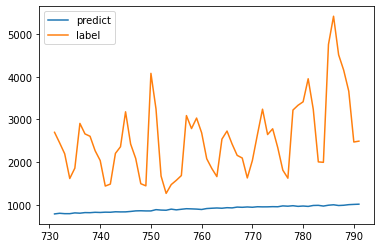

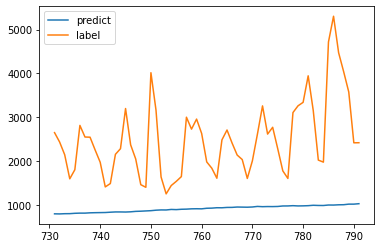

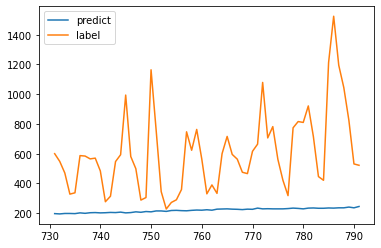

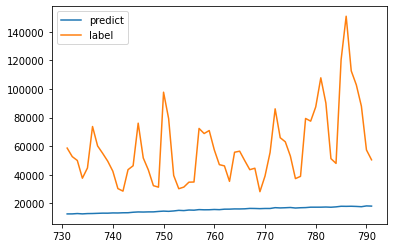

RMSE : 7.126604890931896


In [ ]:
simple.make_val_plot(val, train_split)